# 🔬 Final ViT Chest X-ray Multi-Label Classification

**Comprehensive Implementation - Group 1 Deep Learning Project**

---

## Table of Contents
1. [Setup & Configuration](#1-setup--configuration)
2. [Data Pipeline](#2-data-pipeline)
3. [Model Architectures](#3-model-architectures)
4. [Training Infrastructure](#4-training-infrastructure)
5. [Evaluation & Visualization](#5-evaluation--visualization)
6. [Results Export](#6-results-export)

---

**Reference Paper:** [arXiv:2406.00237](https://arxiv.org/abs/2406.00237)  
**Original Repo:** [Aviral-03/ViT-Chest-Xray](https://github.com/Aviral-03/ViT-Chest-Xray)

## 1. Setup & Configuration

In [1]:
# =============================================================================
# REPRODUCIBILITY SETUP
# =============================================================================
import random
import numpy as np
import torch

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to: {SEED}")

Random seed set to: 42


In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import os
import sys
import glob
import math
import json
import warnings
from datetime import datetime
from pathlib import Path

# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.transforms as transforms

# Models
try:
    import timm
    TIMM_AVAILABLE = True
except ImportError:
    TIMM_AVAILABLE = False
    print("Warning: timm not installed. Pre-trained ViT models unavailable.")

# Metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import cycle
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

# Print versions
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
if TIMM_AVAILABLE:
    print(f"timm: {timm.__version__}")

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
PyTorch: 2.10.0+cu126
NumPy: 2.4.1
Pandas: 3.0.0
timm: 1.0.24


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    """Centralized configuration for the experiment."""
    
    # Paths (use pathlib for cross-platform compatibility)
    PROJECT_ROOT = Path(os.getcwd()).parent if Path(os.getcwd()).name == "Project" else Path(os.getcwd())
    DATA_ROOT = PROJECT_ROOT / "Project" / "input"
    IMAGES_DIR = DATA_ROOT  # Images are in input folder directly
    LABELS_CSV = DATA_ROOT / "Data_Entry_2017_v2020.csv"
    OUTPUT_DIR = PROJECT_ROOT / "Project" / "files"
    ARTIFACTS_DIR = PROJECT_ROOT / "Project" / "artifacts"
    
    # Create directories
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Dataset labels (NIH Chest X-ray 14 + No Finding)
    LABELS = [
        'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule',
        'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass',
        'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia',
        'No Finding'
    ]
    NUM_CLASSES = len(LABELS)
    
    # Image settings
    IMAGE_SIZE = 224
    
    # Training hyperparameters
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 10
    EARLY_STOPPING_PATIENCE = 5
    
    # ViT specific
    PATCH_SIZE = 32
    PROJECTION_DIM = 64
    NUM_HEADS = 4
    TRANSFORMER_LAYERS = 8
    MLP_HEAD_UNITS = [2048, 1024]
    
    # Evaluation
    THRESHOLD = 0.5
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Sample size (for demo/testing)
    SAMPLE_SIZE = None  # Set to integer for quick testing, None for full data
    
    @classmethod
    def to_dict(cls):
        """Export configuration as dictionary."""
        return {
            'image_size': cls.IMAGE_SIZE,
            'batch_size': cls.BATCH_SIZE,
            'learning_rate': cls.LEARNING_RATE,
            'weight_decay': cls.WEIGHT_DECAY,
            'num_epochs': cls.NUM_EPOCHS,
            'patch_size': cls.PATCH_SIZE,
            'projection_dim': cls.PROJECTION_DIM,
            'num_heads': cls.NUM_HEADS,
            'transformer_layers': cls.TRANSFORMER_LAYERS,
            'num_classes': cls.NUM_CLASSES,
            'threshold': cls.THRESHOLD,
            'seed': SEED,
            'device': str(cls.DEVICE),
            'timestamp': datetime.now().isoformat()
        }
    
    @classmethod
    def save(cls, filepath=None):
        """Save configuration to JSON."""
        if filepath is None:
            filepath = cls.ARTIFACTS_DIR / 'config.json'
        with open(filepath, 'w') as f:
            json.dump(cls.to_dict(), f, indent=2)
        print(f"Config saved to: {filepath}")

# Print configuration
print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
for key, value in Config.to_dict().items():
    print(f"  {key}: {value}")
print("=" * 60)

CONFIGURATION
  image_size: 224
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 1e-05
  num_epochs: 10
  patch_size: 32
  projection_dim: 64
  num_heads: 4
  transformer_layers: 8
  num_classes: 15
  threshold: 0.5
  seed: 42
  device: cuda
  timestamp: 2026-02-04T09:01:55.076235


In [4]:
# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================
device = Config.DEVICE
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 12.6
GPU Memory: 6.4 GB


## 2. Data Pipeline

### ⚠️ Important Notes:
- **Patient-Level Split**: NIH dataset should be split by Patient ID to avoid data leakage
- **Horizontal Flip Warning**: Avoid aggressive horizontal flipping as it reverses anatomical orientation
- **Grayscale to RGB**: X-rays are grayscale but models expect RGB

In [5]:
# =============================================================================
# DATA PARSER
# =============================================================================
class DatasetParser:
    """Parse and prepare NIH Chest X-ray dataset."""
    
    def __init__(self, data_root, labels_csv, labels_list):
        self.data_root = Path(data_root)
        self.labels_list = labels_list
        
        # Load labels CSV
        self.labels_df = pd.read_csv(labels_csv)
        
        # Find available images
        self.image_paths = list(self.data_root.glob('*.png'))
        self.available_images = {p.name for p in self.image_paths}
        
        # Filter to available images only
        self.labels_df = self.labels_df[
            self.labels_df['Image Index'].isin(self.available_images)
        ].reset_index(drop=True)
        
        # Parse multi-labels
        self.labels_df['Labels'] = self.labels_df['Finding Labels'].apply(
            lambda x: x.split('|')
        )
        
        # Extract Patient ID from filename (format: 00000001_000.png)
        # Note: NIH dataset doesn't have Patient ID column, we extract from filename
        self.labels_df['Patient ID'] = self.labels_df['Image Index'].apply(
            lambda x: x.split('_')[0]
        )
        
    def get_patient_level_split(self, test_size=0.2, val_size=0.125, random_state=42):
        """
        Split data by Patient ID to avoid data leakage.
        
        Returns:
            train_df, val_df, test_df: DataFrames with image-level data
        """
        # Get unique patient IDs
        patient_ids = self.labels_df['Patient ID'].unique()
        print(f"Total patients: {len(patient_ids)}")
        
        # Split patients
        train_val_patients, test_patients = train_test_split(
            patient_ids, test_size=test_size, random_state=random_state
        )
        train_patients, val_patients = train_test_split(
            train_val_patients, test_size=val_size, random_state=random_state
        )
        
        # Split dataframes
        train_df = self.labels_df[self.labels_df['Patient ID'].isin(train_patients)].reset_index(drop=True)
        val_df = self.labels_df[self.labels_df['Patient ID'].isin(val_patients)].reset_index(drop=True)
        test_df = self.labels_df[self.labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)
        
        print(f"Train: {len(train_df)} images from {len(train_patients)} patients")
        print(f"Val: {len(val_df)} images from {len(val_patients)} patients")
        print(f"Test: {len(test_df)} images from {len(test_patients)} patients")
        
        return train_df, val_df, test_df
    
    def get_image_level_split(self, test_size=0.2, val_size=0.125, random_state=42):
        """
        Standard image-level split (may cause patient leakage).
        Use only if patient-level split is not possible.
        """
        print("⚠️ WARNING: Image-level split may cause patient data leakage!")
        
        train_val_df, test_df = train_test_split(
            self.labels_df, test_size=test_size, random_state=random_state
        )
        train_df, val_df = train_test_split(
            train_val_df, test_size=val_size, random_state=random_state
        )
        
        return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)
    
    def sample(self, n_samples, weighted=True, random_state=42):
        """Sample a subset of data."""
        if weighted:
            weights = self.labels_df['Labels'].apply(len).values + 0.04
            weights /= weights.sum()
            return self.labels_df.sample(n_samples, weights=weights, random_state=random_state)
        return self.labels_df.sample(n_samples, random_state=random_state)
    
    def get_class_distribution(self):
        """Get label distribution for class imbalance analysis."""
        counts = {label: 0 for label in self.labels_list}
        for labels in self.labels_df['Labels']:
            for label in labels:
                if label in counts:
                    counts[label] += 1
        return counts

In [6]:
# =============================================================================
# LOAD AND PARSE DATA
# =============================================================================
print("Loading dataset...")
print(f"Data root: {Config.DATA_ROOT}")
print(f"Labels CSV: {Config.LABELS_CSV}")

# Check if data exists
if not Config.LABELS_CSV.exists():
    print(f"\n❌ ERROR: Labels CSV not found at {Config.LABELS_CSV}")
    print("Please download the NIH Chest X-ray dataset first.")
else:
    parser = DatasetParser(
        data_root=Config.IMAGES_DIR,
        labels_csv=Config.LABELS_CSV,
        labels_list=Config.LABELS
    )
    
    print(f"\nTotal images found: {len(parser.labels_df)}")
    
    # Show class distribution
    class_dist = parser.get_class_distribution()
    print("\nClass distribution:")
    for label, count in sorted(class_dist.items(), key=lambda x: -x[1]):
        print(f"  {label}: {count}")

Loading dataset...
Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Labels CSV: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input\Data_Entry_2017_v2020.csv

Total images found: 112120

Class distribution:
  No Finding: 60361
  Infiltration: 19894
  Effusion: 13317
  Atelectasis: 11559
  Nodule: 6331
  Mass: 5782
  Pneumothorax: 5302
  Consolidation: 4667
  Pleural_Thickening: 3385
  Cardiomegaly: 2776
  Emphysema: 2516
  Edema: 2303
  Fibrosis: 1686
  Pneumonia: 1431
  Hernia: 227


In [7]:
# =============================================================================
# PREPARE DATA SPLITS
# =============================================================================
# Use sample for quick testing, or full data for real training
if Config.SAMPLE_SIZE is not None:
    print(f"\n⚡ Using sample of {Config.SAMPLE_SIZE} images for quick testing")
    df = parser.sample(Config.SAMPLE_SIZE, weighted=True)
    # For sample, use image-level split
    train_df, val_df, test_df = train_test_split(
        df, test_size=0.2, random_state=SEED
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.125, random_state=SEED
    )
else:
    print("\n📊 Using full dataset with patient-level split")
    train_df, val_df, test_df = parser.get_patient_level_split(
        test_size=0.2, val_size=0.125, random_state=SEED
    )


📊 Using full dataset with patient-level split
Total patients: 30805
Train: 78614 images from 21563 patients
Val: 11212 images from 3081 patients
Test: 22294 images from 6161 patients


In [8]:
# =============================================================================
# PYTORCH DATASET
# =============================================================================
class ChestXrayDataset(Dataset):
    """
    PyTorch Dataset for NIH Chest X-ray multi-label classification.
    """
    
    def __init__(self, dataframe, images_path, labels_list, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.images_path = Path(images_path)
        self.labels_list = labels_list
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = self.images_path / row['Image Index']
        
        # Load image (grayscale X-ray converted to RGB)
        image = cv2.imread(str(img_path))
        if image is None:
            # Handle missing image
            image = np.zeros((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # Multi-label encoding
        labels = row['Labels'] if isinstance(row['Labels'], list) else row['Labels'].split('|')
        one_hot = torch.zeros(len(self.labels_list), dtype=torch.float32)
        for label in labels:
            if label in self.labels_list:
                one_hot[self.labels_list.index(label)] = 1.0
        
        if self.transform:
            image = self.transform(image)
        
        return image, one_hot

In [9]:
# =============================================================================
# DATA TRANSFORMS
# =============================================================================
# Training augmentation
# ⚠️ Note: Horizontal flip is included but should be used carefully for medical images
#          as it reverses anatomical orientation (e.g., heart position)
train_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),  # Reduced probability
    transforms.RandomRotation(degrees=5),    # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test transform (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Transforms defined:")
print(f"  Train: {train_transform}")
print(f"  Val/Test: {val_test_transform}")

Transforms defined:
  Train: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.3)
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
  Val/Test: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [10]:
# =============================================================================
# CREATE DATASETS AND DATALOADERS
# =============================================================================
train_dataset = ChestXrayDataset(
    train_df, Config.IMAGES_DIR, Config.LABELS, transform=train_transform
)
val_dataset = ChestXrayDataset(
    val_df, Config.IMAGES_DIR, Config.LABELS, transform=val_test_transform
)
test_dataset = ChestXrayDataset(
    test_df, Config.IMAGES_DIR, Config.LABELS, transform=val_test_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

print(f"\nDatasets created:")
print(f"  Train: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"  Val: {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"  Test: {len(test_dataset)} samples, {len(test_loader)} batches")


Datasets created:
  Train: 78614 samples, 2457 batches
  Val: 11212 samples, 351 batches
  Test: 22294 samples, 697 batches


## 3. Model Architectures

In [11]:
# =============================================================================
# CNN BASELINE MODEL
# =============================================================================
class CNNClassifier(nn.Module):
    """Simple CNN baseline for comparison."""
    
    def __init__(self, num_classes=15):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Calculate flatten size: 224->222->111->109->54
        self.flatten_size = 64 * 54 * 54
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# =============================================================================
# RESNET-34 MODEL
# =============================================================================
class BasicBlock(nn.Module):
    """ResNet Basic Block."""
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    """ResNet-34 Architecture."""
    
    def __init__(self, block, layers, num_classes=15):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self._init_weights()
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = torch.flatten(self.avgpool(x), 1)
        x = self.fc(x)
        return x

def create_resnet34(num_classes=15):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

In [13]:
# =============================================================================
# VISION TRANSFORMER (FROM SCRATCH)
# =============================================================================
class MLP(nn.Module):
    """MLP block for Transformer."""
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class PatchEmbedding(nn.Module):
    """Patch Embedding Layer."""
    def __init__(self, img_size=224, patch_size=32, in_channels=3, embed_dim=64):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class TransformerEncoderBlock(nn.Module):
    """Transformer Encoder Block."""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), embed_dim, dropout)
        
    def forward(self, x):
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        x = x + self.mlp(self.ln2(x))
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer from scratch."""
    
    def __init__(self, img_size=224, patch_size=32, in_channels=3, num_classes=15,
                 embed_dim=64, depth=8, num_heads=4, mlp_ratio=2, dropout=0.1):
        super().__init__()
        
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.ln = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Sequential(
            nn.Linear(embed_dim * self.num_patches, 2048),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.ln(x)
        x = x.flatten(1)
        x = self.head(x)
        return x

In [14]:
# =============================================================================
# PRE-TRAINED VIT (using timm)
# =============================================================================
def create_pretrained_vit(num_classes=15, model_name='vit_base_patch16_224'):
    """Create pre-trained ViT model using timm."""
    if not TIMM_AVAILABLE:
        raise ImportError("timm library required for pre-trained ViT")
    
    model = timm.create_model(model_name, pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

print("Model architectures defined:")
print("  - CNNClassifier")
print("  - ResNet-34")
print("  - VisionTransformer (scratch)")
print("  - Pre-trained ViT (timm)")

Model architectures defined:
  - CNNClassifier
  - ResNet-34
  - VisionTransformer (scratch)
  - Pre-trained ViT (timm)


## 4. Training Infrastructure

In [15]:
# =============================================================================
# EVALUATION METRICS
# =============================================================================
def compute_metrics(targets, outputs, threshold=0.5):
    """
    Compute multi-label classification metrics.
    
    Returns:
        dict with accuracy, macro_auc, per_class_auc
    """
    preds = (outputs > threshold).astype(int)
    
    # Element-wise accuracy
    accuracy = (preds == targets).mean() * 100
    
    # Per-class AUC (only for classes with both 0 and 1)
    per_class_auc = {}
    valid_classes = []
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:, i])) > 1:
            valid_classes.append(i)
            per_class_auc[Config.LABELS[i]] = roc_auc_score(targets[:, i], outputs[:, i])
    
    # Macro AUC (only valid classes)
    if len(valid_classes) > 0:
        macro_auc = roc_auc_score(
            targets[:, valid_classes],
            outputs[:, valid_classes],
            average='macro'
        )
    else:
        macro_auc = 0.0
    
    return {
        'accuracy': accuracy,
        'macro_auc': macro_auc,
        'per_class_auc': per_class_auc,
        'valid_classes': len(valid_classes)
    }

In [16]:
# =============================================================================
# TRAINING FUNCTION
# =============================================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler=None, num_epochs=10, patience=5, save_path=None, model_name='model'):
    """
    Train model with early stopping and comprehensive logging.
    
    Args:
        model: PyTorch model
        train_loader, val_loader: DataLoaders
        criterion: Loss function (BCEWithLogitsLoss recommended)
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        save_path: Path to save best model
        model_name: Name for logging
        
    Returns:
        history: Training history dictionary
    """
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': [],
        'lr': []
    }
    
    best_val_auc = 0.0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        all_train_targets = []
        all_train_outputs = []
        
        train_pbar = tqdm(train_loader, desc=f'[{model_name}] Epoch {epoch+1}/{num_epochs} Train')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            all_train_targets.append(labels.cpu().numpy())
            all_train_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Compute training metrics
        train_loss /= len(train_loader.dataset)
        train_targets = np.vstack(all_train_targets)
        train_outputs = np.vstack(all_train_outputs)
        train_metrics = compute_metrics(train_targets, train_outputs)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_metrics['accuracy'])
        history['train_auc'].append(train_metrics['macro_auc'])
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_val_targets = []
        all_val_outputs = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                all_val_targets.append(labels.cpu().numpy())
                all_val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        # Compute validation metrics
        val_loss /= len(val_loader.dataset)
        val_targets = np.vstack(all_val_targets)
        val_outputs = np.vstack(all_val_outputs)
        val_metrics = compute_metrics(val_targets, val_outputs)
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_auc'].append(val_metrics['macro_auc'])
        
        # Learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} (lr={current_lr:.6f}):')
        print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_metrics["accuracy"]:.2f}%, AUC: {train_metrics["macro_auc"]:.4f}')
        print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_metrics["accuracy"]:.2f}%, AUC: {val_metrics["macro_auc"]:.4f}')
        
        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save best model (by AUC)
        if val_metrics['macro_auc'] > best_val_auc:
            best_val_auc = val_metrics['macro_auc']
            patience_counter = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f'  >> Saved best model with val_auc: {best_val_auc:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\n>> Early stopping at epoch {epoch+1}')
                break
    
    return history

In [17]:
# =============================================================================
# EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, test_loader, criterion):
    """
    Evaluate model on test set.
    
    Returns:
        test_loss, metrics_dict, all_targets, all_outputs
    """
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    targets = np.vstack(all_targets)
    outputs = np.vstack(all_outputs)
    metrics = compute_metrics(targets, outputs)
    
    print(f"\nTest Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.2f}%")
    print(f"  Macro AUC: {metrics['macro_auc']:.4f}")
    print(f"\nPer-class AUC:")
    for label, auc_val in sorted(metrics['per_class_auc'].items(), key=lambda x: -x[1]):
        print(f"    {label}: {auc_val:.4f}")
    
    return test_loss, metrics, targets, outputs

## 5. Evaluation & Visualization

In [18]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================
def plot_training_history(history, model_name='Model', save_path=None):
    """Plot training history."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name}: Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train')
    axes[1].plot(history['val_acc'], label='Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name}: Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # AUC
    axes[2].plot(history['train_auc'], label='Train')
    axes[2].plot(history['val_auc'], label='Val')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title(f'{model_name}: AUC')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_roc_curves(targets, outputs, class_labels, title='ROC Curves', save_path=None):
    """Plot ROC curves for multi-label classification."""
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))
    
    macro_fpr = []
    macro_tpr = []
    
    for i, (label, color) in enumerate(zip(class_labels, colors)):
        if len(np.unique(targets[:, i])) > 1:
            fpr, tpr, _ = roc_curve(targets[:, i], outputs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 6. Results Export

In [19]:
# =============================================================================
# RESULTS EXPORT FUNCTIONS
# =============================================================================
def save_results(results_dict, filepath):
    """Save results to JSON."""
    with open(filepath, 'w') as f:
        json.dump(results_dict, f, indent=2)
    print(f"Results saved to: {filepath}")

def create_summary_table(all_results):
    """Create summary DataFrame from all model results."""
    rows = []
    for model_name, results in all_results.items():
        rows.append({
            'Model': model_name,
            'Test Loss': results.get('test_loss', 'N/A'),
            'Accuracy (%)': results.get('accuracy', 'N/A'),
            'Macro AUC': results.get('macro_auc', 'N/A'),
            'Parameters': results.get('parameters', 'N/A')
        })
    return pd.DataFrame(rows)

def export_artifacts():
    """Export all artifacts to artifacts directory."""
    print(f"\nExporting artifacts to: {Config.ARTIFACTS_DIR}")
    
    # Save config
    Config.save()
    
    print("Artifacts exported successfully!")

---

## 🚀 Run Training (Example)

Below is an example of how to train and evaluate a model. Uncomment and modify as needed.

[ViT] Epoch 1/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/10 (lr=0.000100):
  Train - Loss: 0.2157, Acc: 92.51%, AUC: 0.6035
  Val   - Loss: 0.2040, Acc: 92.80%, AUC: 0.6680
  >> Saved best model with val_auc: 0.6680


[ViT] Epoch 2/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 2/10 (lr=0.000100):
  Train - Loss: 0.2078, Acc: 92.74%, AUC: 0.6505
  Val   - Loss: 0.1999, Acc: 92.93%, AUC: 0.6999
  >> Saved best model with val_auc: 0.6999


[ViT] Epoch 3/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 3/10 (lr=0.000100):
  Train - Loss: 0.2054, Acc: 92.80%, AUC: 0.6644
  Val   - Loss: 0.1998, Acc: 92.89%, AUC: 0.6965


[ViT] Epoch 4/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 4/10 (lr=0.000100):
  Train - Loss: 0.2037, Acc: 92.83%, AUC: 0.6797
  Val   - Loss: 0.1988, Acc: 92.93%, AUC: 0.7048
  >> Saved best model with val_auc: 0.7048


[ViT] Epoch 5/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 5/10 (lr=0.000100):
  Train - Loss: 0.2025, Acc: 92.85%, AUC: 0.6883
  Val   - Loss: 0.1980, Acc: 92.94%, AUC: 0.7144
  >> Saved best model with val_auc: 0.7144


[ViT] Epoch 6/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 6/10 (lr=0.000100):
  Train - Loss: 0.2014, Acc: 92.87%, AUC: 0.6961
  Val   - Loss: 0.1965, Acc: 93.04%, AUC: 0.7212
  >> Saved best model with val_auc: 0.7212


[ViT] Epoch 7/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 7/10 (lr=0.000100):
  Train - Loss: 0.2008, Acc: 92.89%, AUC: 0.7013
  Val   - Loss: 0.1984, Acc: 92.95%, AUC: 0.7174


[ViT] Epoch 8/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 8/10 (lr=0.000100):
  Train - Loss: 0.2000, Acc: 92.89%, AUC: 0.7097
  Val   - Loss: 0.1963, Acc: 93.02%, AUC: 0.7244
  >> Saved best model with val_auc: 0.7244


[ViT] Epoch 9/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 9/10 (lr=0.000100):
  Train - Loss: 0.1993, Acc: 92.93%, AUC: 0.7129
  Val   - Loss: 0.1967, Acc: 92.99%, AUC: 0.7272
  >> Saved best model with val_auc: 0.7272


[ViT] Epoch 10/10 Train:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 10/10 (lr=0.000100):
  Train - Loss: 0.1985, Acc: 92.93%, AUC: 0.7195
  Val   - Loss: 0.1967, Acc: 93.01%, AUC: 0.7264


Evaluating:   0%|          | 0/697 [00:00<?, ?it/s]


Test Results:
  Loss: 0.2001
  Accuracy: 92.91%
  Macro AUC: 0.7225

Per-class AUC:
    Edema: 0.8422
    Cardiomegaly: 0.7996
    Effusion: 0.7880
    Consolidation: 0.7615
    Pneumothorax: 0.7540
    Hernia: 0.7460
    Emphysema: 0.7375
    Atelectasis: 0.7170
    No Finding: 0.7114
    Pleural_Thickening: 0.6997
    Fibrosis: 0.6977
    Mass: 0.6762
    Pneumonia: 0.6710
    Infiltration: 0.6614
    Nodule: 0.5747


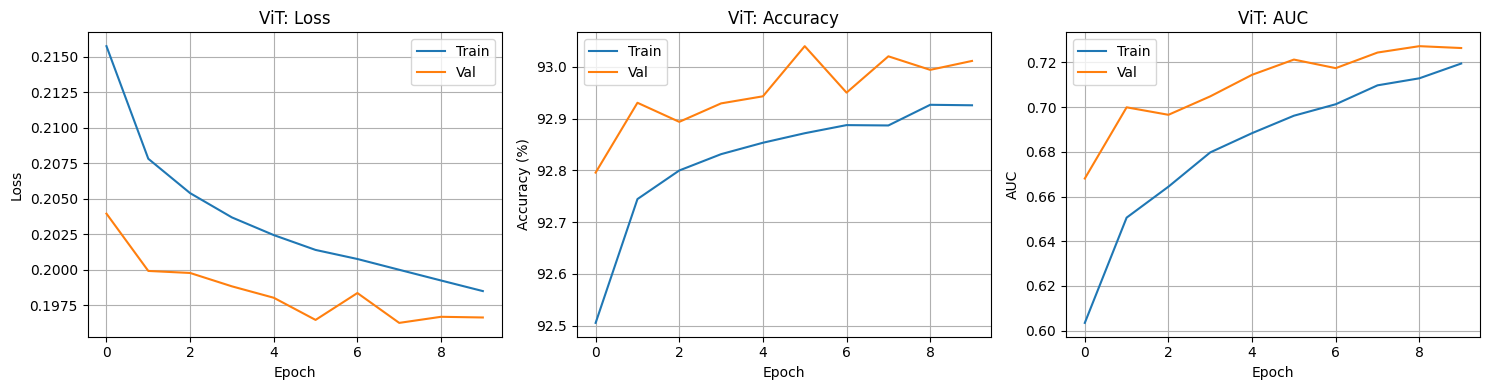

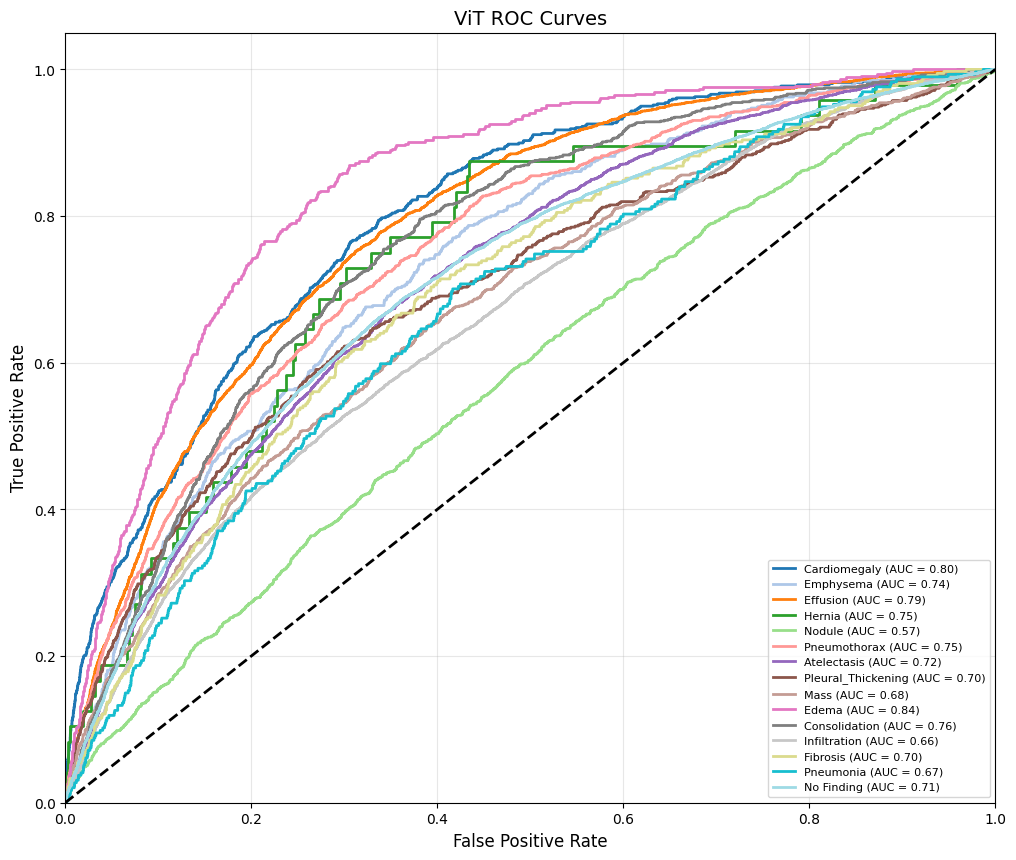

Training example code ready. Uncomment to run.


In [20]:
# =============================================================================
# EXAMPLE: TRAIN VIT MODEL
# =============================================================================

# Create model
vit_model = VisionTransformer(
    img_size=Config.IMAGE_SIZE,
    patch_size=Config.PATCH_SIZE,
    num_classes=Config.NUM_CLASSES,
    embed_dim=Config.PROJECTION_DIM,
    depth=Config.TRANSFORMER_LAYERS,
    num_heads=Config.NUM_HEADS
).to(device)

# Setup training
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train
history = train_model(
    vit_model, train_loader, val_loader, criterion, optimizer,
    scheduler=scheduler, num_epochs=Config.NUM_EPOCHS,
    patience=Config.EARLY_STOPPING_PATIENCE,
    save_path=Config.OUTPUT_DIR / 'vit_best.pth',
    model_name='ViT'
)

# Evaluate
test_loss, metrics, targets, outputs = evaluate_model(vit_model, test_loader, criterion)

# Visualize
plot_training_history(history, 'ViT', Config.ARTIFACTS_DIR / 'vit_training.png')
plot_roc_curves(targets, outputs, Config.LABELS, 'ViT ROC Curves', Config.ARTIFACTS_DIR / 'vit_roc.png')

print("Training example code ready. Uncomment to run.")

In [21]:
# =============================================================================
# EXPORT CONFIGURATION AND SUMMARY
# =============================================================================
export_artifacts()

print("\n" + "="*60)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*60)
print(f"Configuration saved to: {Config.ARTIFACTS_DIR / 'config.json'}")
print(f"Model checkpoints in: {Config.OUTPUT_DIR}")
print(f"Visualizations in: {Config.ARTIFACTS_DIR}")


Exporting artifacts to: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\artifacts
Config saved to: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\artifacts\config.json
Artifacts exported successfully!

NOTEBOOK EXECUTION COMPLETE
Configuration saved to: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\artifacts\config.json
Model checkpoints in: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\files
Visualizations in: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\artifacts
